<a href="https://colab.research.google.com/github/elienhanj/sentiment_analysis/blob/main/sentiment_hs_nohs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisis Sentimen Tweet - Text Mining**

Elien Hanjani Pramitha - Telkom DTI 2020 - DS0108.

*   Model analisis yang akan dibangun menggunakan data tweet dengan 2 kolom yaitu kolom tweet dan kolom label kelas hatespeech dan non hatespeech. 
*   Preprocessing data dilakukan dengan melakukan penyeimbangan data karena dataset awal merupakan imbalanced data, dimana jumlah data berlabel hatespeech dan non hatespeech tidak seimbang. Teknik balanced data yang dilakukan menggunakan metode undersampling (memotong jumlah kelas yang berlimpah sehingga jumlahnya menjadi sama dengan kelas lainnya). Kenapa hal ini harus dilakukan? karena pada dasarnya data yang imbalanced merupakan masalah umum dalam machine learning. Jika dipaksakan melakukan pemodelan, maka model akan sia-sia walaupun memiliki akurasi yang tinggi.
*   Dalam tahap preprocessing text dilakukan untuk menghapus mentions, hasgtag, retweets, urls, case folding, tokenization, stopword dan stemming.
*   Vektorisasi dilakukan menggunakan TF-IDF.
*   Pemodelan menggunakan algoritma multinomial naive bayes classifier. Algoritma ini sangat baik untuk memproses hasil vektor dari TF-IDF, tetapi tidak bisa mengatasi data negatif. Maka dilakukan scaling agar data vektor hasil TF-IDF tidak ada yang bernilai negatif.
*   Evaluasi model dilakukan dengan confussion matrix sehingga juga dapat mengetahui nilai TP, FP, TN, FN.





## **Import Data**

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/elienhanj/sentiment_analysis/main/dataready.csv' , sep=",")
df.head()

,Tweet,Label
0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,Non_HS
1,RT @baguscondromowo: Mereka terus melukai aksi...,Non_HS
2,Sylvi: bagaimana gurbernur melakukan kekerasan...,Non_HS
3,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",Non_HS
4,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,Non_HS


## **Preprocessing Data**

In [2]:
print(df.isnull().values.any())

True


Data ada yang kosong

In [3]:
#menghapus data yang kosong pada row Tweet
df = df.dropna(axis=0, subset=['Tweet'])
print(df)

                                                 Tweet   Label
0    RT @spardaxyz: Fadli Zon Minta Mendagri Segera...  Non_HS
1    RT @baguscondromowo: Mereka terus melukai aksi...  Non_HS
2    Sylvi: bagaimana gurbernur melakukan kekerasan...  Non_HS
3    Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...  Non_HS
4    RT @lisdaulay28: Waspada KTP palsu.....kawal P...  Non_HS
..                                                 ...     ...
708  Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....      HS
709  Betul bang hancurkan merka bang, musnahkan chi...      HS
710  Sapa Yg bilang Ahok anti korupsi!?, klo grombo...      HS
711  Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...      HS
712  Mudah2an gw ketemu sama SI BABI IWAN BOPENG DI...      HS

[712 rows x 2 columns]


In [4]:
print(df.isnull().values.any())

False


Data kosong berhasil dihapus, sehingga semua data benar-benar terisi baik kolom tweet maupun label.

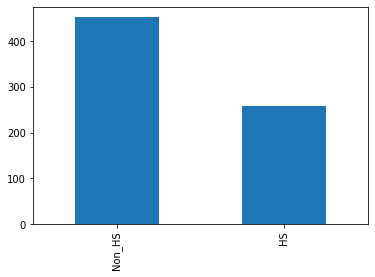

In [5]:
#cek proporsi label data
pd.value_counts(df['Label']).plot.bar()

Data imbalanced (tidak seimbang antara label HS dan Non HS)

In [6]:
#melihat total data berlabel
df['Label'].count()

712

In [7]:
#menghitung proporsi data label dengan jumlah yg tidak seimbang
df["Label"].value_counts() 

Non_HS    453
HS        259
Name: Label, dtype: int64

In [8]:
#metode undersampling, menyamakan jumlah kelas HS dan Non HS
df_set_NonHS = df.loc[df['Label'] == 'Non_HS']
df_set_NonHS = df_set_NonHS.head(259)

In [9]:
#metode undersampling, menyamakan jumlah kelas HS dan Non HS
df_set_HS = df.loc[df['Label'] == 'HS']
df_set_HS = df_set_HS.head(259)

In [10]:
df_fix = df_set_NonHS.append(df_set_HS, ignore_index=True)

In [11]:
df_fix

,Tweet,Label
0,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,Non_HS
1,RT @baguscondromowo: Mereka terus melukai aksi...,Non_HS
2,Sylvi: bagaimana gurbernur melakukan kekerasan...,Non_HS
3,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",Non_HS
4,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,Non_HS
...,...,...
513,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,HS
514,"Betul bang hancurkan merka bang, musnahkan chi...",HS
515,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",HS
516,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",HS


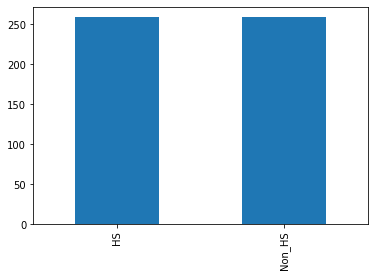

In [12]:
pd.value_counts(df_fix['Label']).plot.bar()

Data berhasil di resampling sehingga jumlah kelas menjadi seimbang

## **Preprocessing Text**

In [ ]:
pip install Sastrawi

     |████████████████████████████████| 215kB 5.2MB/s 


In [ ]:
pip install nltk

In [ ]:
# Cleaning the tweets
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
def preprocessing(a,b):
    data_fix = []
    from nltk.corpus import stopwords
    for i in range(len(b)):
        teks = re.sub('[^a-zA-Z]', ' ', a[i])
        # Remove mentions
        teks = re.sub(r'@[A-Za-z0-9_]+', '', a[i])
        # Remove hashtags
        teks = re.sub(r'#', '', a[i])
        # Remove retweets:
        teks = re.sub(r'RT : ', '', a[i])
        # Remove urls
        teks = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', a[i])
        #Case Folding
        teks = teks.lower()
        #Tokinize
        teks = teks.split()
        #Stopword + Stemming
        stemmer = StemmerFactory().create_stemmer()        
        teks = [stemmer.stem(word) for word in teks if not word in set(stopwords.words('indonesian'))]
        teks = [word for word in teks if len (word) > 3]
        teks = ' '.join(teks)
        data_fix.append(teks)
    return data_fix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
panjang_set = df_fix['Label'].tolist()

In [ ]:
data_set = preprocessing(df_fix['Tweet'],panjang_set)

In [ ]:
data_set

['fadli mendagri nonaktif ahok gubernur https t co kh5virwpdo',
 'luka aksi rangka penjara ahok ahok gagal pilkada',
 'sylvi gurbernur keras perempuan bukti ibu2 foto bareng debatfinalpilkadajkt',
 'ahmad dhani puas debat pilkada jalan bekas ungkap https t co m3hoppluid u2026',
 'waspada palsu kawal pilkada https t co oooerqv4sm',
 'bnyak agam bahas pilkada terus tingkat iman batas pilkada',
 'maksud nyata anda amin kriminalisasi ahok hati2 mulut https t co h4odvay0md',
 'ahok integrasi transportasi publik sistem single ticketing u2026 https t co 42ph7pqv0b infotribun',
 'ahok lawan korupsi ibukota bangun infrastruktur coba baik trobosan works well',
 'awas curang pilkada agus sylvi pakai aplikasi https t co xwzw4nufiu',
 'jokowi ahok kalem lengkap',
 'makan istana undang makan istana gebang tapi https t co ns6cuycpuj',
 'cuti habis ahok gubernur lagi amat republika online https t co t3kzvq9e4e',
 'debat pilkada jakarta gelar jumat malam https t co e9ixz6jllr',
 'demonstran malteng des

In [ ]:
df_fix['Prepro'] = pd.Series(data_set).values

In [ ]:
df_fix

,Tweet,Label,Prepro
0,Fadli Zon Minta Mendagri Segera Menonaktifkan ...,Non_HS,fadli mendagri nonaktif ahok gubernur https t ...
1,Mereka terus melukai aksi dalam rangka memenja...,Non_HS,luka aksi rangka penjara ahok ahok gagal pilkada
2,Sylvi: bagaimana gurbernur melakukan kekerasan...,Non_HS,sylvi gurbernur keras perempuan bukti ibu2 fot...
3,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",Non_HS,ahmad dhani puas debat pilkada jalan bekas ung...
4,Waspada KTP palsu.....kawal PILKADA https:\/\/...,Non_HS,waspada palsu kawal pilkada https t co oooerqv4sm
...,...,...,...
513,Muka Si BABi Ahok Tuh Yg Mirip SERBET Lantai.....,HS,muka babi ahok serbet lantai
514,"Betul bang hancurkan merka bang, musnahkan chi...",HS,bang hancur merka bang musnah china babi bumi ...
515,"Sapa Yg bilang Ahok anti korupsi!?, klo grombo...",HS,sapa bilang ahok anti korupsi grombolannya ngo...
516,"Gw juga ngimpi SENTILIN BIJI BABI AHOK, pcetar...",HS,ngimpi sentilin biji babi ahok pcetar pcetar l...


Data yang sudah berhasil dilakukan preprocessing text disimpan dalam kolom baru bernama Prepro yang akan dibangun model analisis sentimen

## **Model Analisis Sentimen**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import metrics

### **Vektorisasi**

In [ ]:
train = df_fix['Prepro']

In [ ]:
train_data = tfidfVectorizer.fit_transform(train)

In [ ]:
train_data.shape

(518, 1766)

In [ ]:
y = df_fix['Label']
y = y.values
X = train_data
X = X.toarray()

### **Multinomial Naive Bayes Classifier**

In [ ]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1)    
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
x_train = Feature_scaler.fit_transform(np.array(x_train))
x_test = Feature_scaler.fit_transform(np.array(x_test))

### **Evaluasi Model**

In [ ]:
# training & evaluasi NB

mnb.fit(x_train, y_train)
y_preds = mnb.predict(x_test)
print(f"Accuracy : ",metrics.accuracy_score(y_test, y_preds))

Accuracy :  0.8653846153846154


In [ ]:
print(confusion_matrix(y_test, y_preds))

[[19  3]
 [ 4 26]]


## **Kesimpulan**

Model yang dibangun menggunakan multinomial naive bayes cukup baik karena menghasilkan akurasi sebesar 86,53%. Akurasi model dapat ditingkatkan dengan menambahkan data dan memperbaiki preprocessing text. Preprocessing text sangat penting dilakukan, apalagi dengan menganalisa data, apa saja preprocessing yang dibutuhkan apa yang harus ditambahkan atau dikurangi agar menghasilkan vektor yang baik dan model yang baik juga.

references :
*   Modul 7 text mining - DTI 2020
*   https://github.com/ialfina/id-hatespeech-detection

